# Transformer Language Models
### For sentiment analysis
Author: [Camilo](https://github.com/camilocarvajalreyes/)

**Objectives**: You will get familiarised with the use of pre-trained models, how to interpret them and implement them in a simple NLP pipeline.

**To do**: Trying a [pre-trained](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) sentiment classifier based on Transformers in an industry case! 

### Instructions
1. Download the vectors, install packages and test if everything is okay (if you haven't done so yet)
2. Load the packages and import vectors by running cells in section 0. We will get familiarised with a pre-trained model that uses Transformers from HuggingFace
3. Read the instructions in Section 1 and implement the model in a sentiment classifiction task.
4. In section 2 we will see how to visualise the attention weights of the model for some examples
5. Don't forget to ask if you have any question

## Section 0 - Importing a pre-trained model
In this tutorial we will use a library called **transformers** from the French company **HuggingFace**. [Transformers](https://github.com/huggingface/transformers) offers more than 40 architectures for NLP based on the [the original transformer module](https://arxiv.org/abs/1706.03762).

In [1]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import pandas as pd

We'll use [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)

This model is a based on the [distilBERT](https://arxiv.org/abs/1910.01108), a lighter version of [BERT](https://arxiv.org/abs/1810.04805) and it has been trained for the [Stanford Sentiment Analysis dataset](https://paperswithcode.com/dataset/sst)

In [2]:
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

First of all we need to do some pre-processing on the input text. Fortunately, HuggingFace includes **Tokenizers** from pre-trained models.

Applying this particular pre-trained model to a tokenised input returns a [SequenceClassifierOutput](https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput) object. More precisely, we can get the **logit** values, which reflect the probability of a Class to be chosen over the other ones.

In this case, we have a **binary sentiment classification**, thus the the logits vector show the odds of the sample being **negative** or **positive** respectively.

In [3]:
input_example = tokenizer("The cutest dog I've ever seen", return_tensors="pt")
output = model(**input_example)
#logits = outputs.logits
#print(logits)
print('Output:')
print(output)
print('Logits:')
print(output.logits)

Output:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.9886,  4.2962]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
Logits:
tensor([[-3.9886,  4.2962]], grad_fn=<AddmmBackward>)


Furthermore, if we happen to have labels for our samples, we can add them when calling the model and it will output the corresponding **loss**. In this case, we know that our phrase is **positive**, the label should be **1**

In [4]:
label = torch.tensor([1]).unsqueeze(0)  # Batch size 1, postive sentiment (label 1)
output = model(**input_example, labels=label) 
print(output.loss)

tensor(0.0003, grad_fn=<NllLossBackward>)


Both outputs are PyTorch tensors, but we can transform it to a **numpy array**.

Remark: the first dimension is 1 because it corresponds to the batch size, which is one since we are only inputing one example

In [5]:
tensor = output.logits
array = tensor.detach().numpy()
print(array.shape)
print(array)

(1, 2)
[[-3.9885974  4.2962294]]


## Section 1 - Clasifying tweets
Let's consider a real case scenario: a major **US Airline** needs you to classify tweets from its costumers. They provide the following [dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment):

Since we won't fine tune the mode, we will only take 2000 out of the ~14000 tweets

In [6]:
full_dataset = pd.read_csv("data/Tweets-subset.csv")
pd.set_option('max_colwidth', 120)
full_dataset = full_dataset.drop(['tweet_id','negativereason','negativereason_confidence','retweet_count',
             'airline','airline_sentiment_gold','name','negativereason_gold',
             'tweet_coord','tweet_created','tweet_location','user_timezone'], axis=1)
dataset = full_dataset[(full_dataset['airline_sentiment']!='neutral')]

# example sentence 
index = 16
print(dataset.iloc[index].text)

dataset.head()

@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???


,airline_sentiment,airline_sentiment_confidence,text
1,positive,0.3486,@VirginAmerica plus you've added commercials to the experience... tacky.
3,negative,1.0000,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have littl..."
4,negative,1.0000,@VirginAmerica and it's a really big bad thing about it
5,negative,1.0000,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad t...
6,positive,0.6745,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"


**1. Using our pre-trained Model, code a function that takes a string of text and outputs 1 if it's positive and 0 if negative**

**Solution**: the easiest way is to use [numpy's argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

In [7]:
import numpy as np
def positive_or_negative(text):
    input_tokens = tokenizer(text, return_tensors="pt")
    output = model(**input_tokens)
    tensor = output.logits
    array = tensor.detach().numpy()
    return np.argmax(array)
positive_or_negative("The cutest dog I've ever seen")

1

**2. Iterate over the dataset and compute the average loss and the accuracy of the classifier**

(This cell should take about 1 minute to run)

For this part we will use the loss integrated in Transformers' output.

In [8]:
true_positive, true_negative, total, sum_loss = 0, 0, 0, 0
for index, row in dataset.iterrows():
    text = row.text
    input_tokens = tokenizer(text, return_tensors="pt")
    if row.airline_sentiment=='positive':
        label = torch.tensor([1]).unsqueeze(0)
        if positive_or_negative(text)==1:
            true_positive += 1
    else:
        label = torch.tensor([0]).unsqueeze(0)
        if positive_or_negative(text)==0:
            true_negative += 1
    total += 1
    output = model(**input_tokens, labels=label)
    sum_loss += output.loss.item()

average_loss = sum_loss/total
accuracy = 100*(true_positive+true_negative)/total
print('average loss = {}'.format(average_loss))
print('accuracy = {}%'.format(accuracy))

average loss = 0.44881485334042215
accuracy = 89.26045016077171%


### Visualising Attention

The airline wishes to understand how the model works. Therefore, you decide to show a visualisation of the attention weights from the first and last layer of transformers. Thankfully, Transformers provides the attention weights when output_attentions=True

In [9]:
def attention(list_text,layer=0):
    ''' parameters:
    text: input string for the classifier
    layer: layer to show the attention weights from
    '''
    input_sentence = tokenizer(list_text, return_tensors="pt",is_split_into_words=True)
    output = model(**input_sentence,output_attentions=True)
    print('text: '+list_text)
    array = output.attentions[layer].detach().numpy()
    array = array.mean(axis=1) # taking average over all attention heads
    return array[0,:,:]

#example
#attention("@VirginAmerica and it's a really big bad thing about it")

**3. Using the attention function, code a heatmap to visualise the scoresfrom the model's self attention**

You can take inspiration from [this example](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html)

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6) # setting figure size

def heatmap_attention(text,layer=0):
    tokenized_sequence = tokenizer.tokenize(text)
    labels = ['[CLS]']+tokenized_sequence+['[SEP]']

    matrix = attention(text,layer=layer)


    fig, ax = plt.subplots()
    im = ax.imshow(matrix)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title("Attention visualisation for our Transformer based classifier")
    fig.tight_layout()
    plt.show()

text: @VirginAmerica and it's a really big bad thing about it


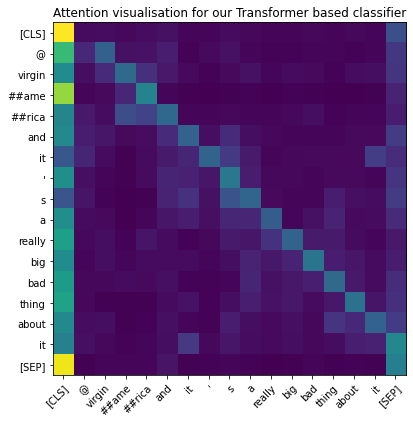

In [11]:
heatmap_attention("@VirginAmerica and it's a really big bad thing about it",layer=1)

### Bonus task
In order to make the task simpler, we have so far ignored neutral tweets.

In [12]:
full_dataset[(full_dataset['airline_sentiment']=='neutral')].head()

,airline_sentiment,airline_sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I need to take another trip!
7,neutral,0.6340,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
10,neutral,0.6769,@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24
23,neutral,1.0000,@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?


**Design a way of predicting that the tweet is neutral**

You may use the attribute **logits** from the model's output

**Solution:**
 There are many possible ones of addressing the problem. We'll make a geometric exploration. Since logits is a 2D vector we can easily plot it. Thus we can see in which geometric region we have more neutral samples. We will only visualise it, but with such information, some machine learning algorithm as K-means or SVM can be applied on data to predict for the three classes.

In [15]:
def logits(text):
    # outputs logits
    input_tokens = tokenizer(text, return_tensors="pt")
    output = model(**input_tokens)
    tensor = output.logits
    return tensor.detach().numpy()

logits_set, colors = [], []
for index, row in full_dataset.iterrows():
    text = row.text
    logits_text = logits(text)
    logits_set.append(logits_text)
    
    if row.airline_sentiment=='positive':
        #label = 1
        colors.append('tab:red')
        
    elif row.airline_sentiment=='negative':
        #label = 0
        colors.append('tab:blue')
    else:
        #label = 2
        colors.append('tab:green')
        
    if index > 200: # we don't need the whole thing
        break

Text(0.5, 1.0, 'Logits from Twitter sentiment dataset')

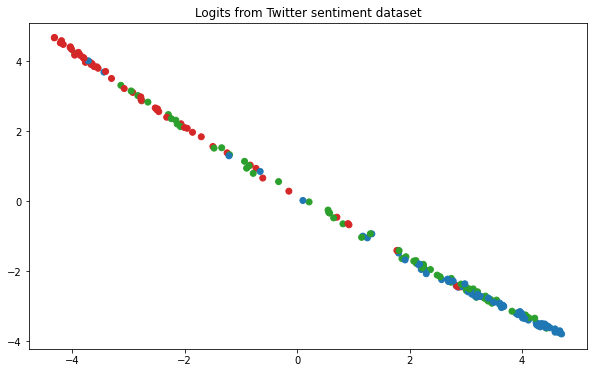

In [19]:
x_vecs, y_vecs = [v[0][0] for v in logits_set], [v[0][1] for v in logits_set]
plt.scatter(x_vecs, y_vecs, c=colors)
plt.title('Logits from Twitter sentiment dataset')

**We can see that such an algorithm would maybe not be accurate, since there's a tendency for neutral tweets to be classified as positive. A better solution would be to actually fine-tune the model on the dataset, because this one is specially trained for binary classification**

### Section 2: More on HuggingFace's transformers

We have used a pre-trained model, but we can fine-tune it for our specific task or data-set. You can find the instructions for doing so in [this tutorial](https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb)

Furthermore, there's an even simpler way of using HuggingFace's pre-trained models: [pipelines](https://github.com/huggingface/transformers/blob/master/notebooks/03-pipelines.ipynb)

In [8]:
from transformers import pipeline

**Example using a sentiment classification task:**

In [9]:
nlp_sentence_classif = pipeline('sentiment-analysis')
nlp_sentence_classif("@VirginAmerica and it's a really big bad thing about it")

[{'label': 'NEGATIVE', 'score': 0.9995822906494141}]

**Example of machine translation**

In [10]:
# English to French
translator = pipeline('translation_en_to_fr')
translator("HuggingFace is a French company that is based in New York City. HuggingFace's mission is to solve NLP one commit at a time")

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

[{'translation_text': 'HuggingFace est une entreprise française basée à New York.'}]